<a href="https://colab.research.google.com/github/QuyMui/HeartDiseaseDiagnosis/blob/main/heartdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mục mới

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, precision_score, classification_report, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

# Sử dụng magic command để hiển thị biểu đồ trong notebook
%matplotlib inline

# Hàm vẽ confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# Hàm vẽ ROC curve
def plot_roc_curve(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


ĐỌC DỮ LIỆU

In [ ]:
# đọc các file csv
import pandas as pd

data= pd.read_csv('/content/drive/MyDrive/PTDL/heart.csv')

In [ ]:
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


EXPLORING THE DATA

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [ ]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [ ]:
data.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

Exploratory Data Analysis : PHÂN TÍCH DỮ LIỆU THĂM DÒ

Heart Attack: 54%
No Heart Attack: 46%



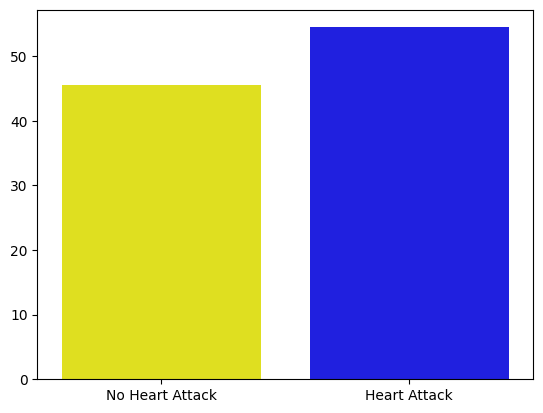

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Tính toán phần trăm mẫu có và không có đau tim
val_counts = data["output"].value_counts()
no_heart_attack = (val_counts[0] / data.shape[0]) * 100
heart_attack = (val_counts[1] / data.shape[0]) * 100

print(f"Heart Attack: {math.floor(heart_attack)}%")
print(f"No Heart Attack: {math.ceil(no_heart_attack)}%")

print()

# Vẽ biểu đồ barplot và đổi màu
sns.barplot(x=["No Heart Attack", "Heart Attack"], y=[no_heart_attack, heart_attack], palette=["yellow", "blue"])
plt.show()

Bộ dữ liệu không có sự chênh lệch nhìu nên không cần phải cân bằng dl

KIỂM TRA SỰ PHÂN BỐ GIỚI TÍNH ĐỐI VỚI BỆNH TIM

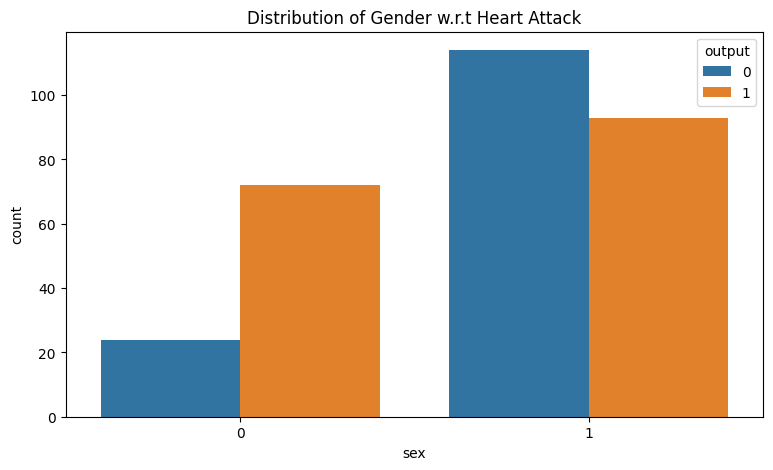

Male heart Attack: 44.927536231884055%
Female heart Attack: 75.0%


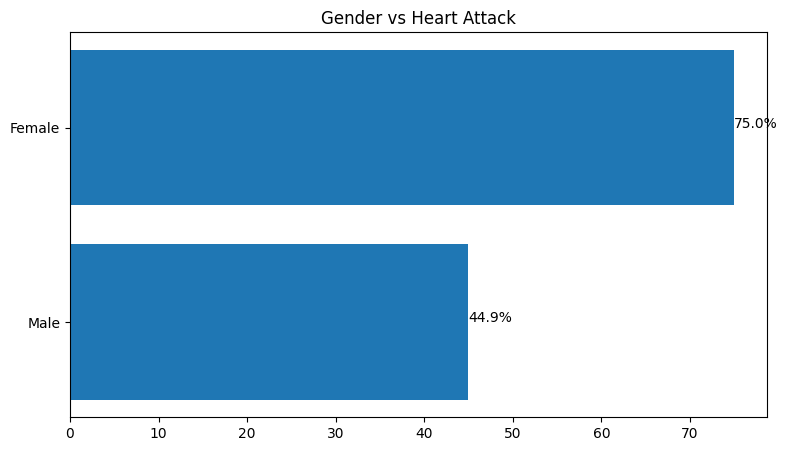

In [ ]:
ax = plt.figure(figsize = (9,5))
sns.countplot(
    data=data,
    x = "sex",
    hue ="output",
)
plt.title("Distribution of Gender w.r.t Heart Attack")
plt.show()

val_counts = data.groupby("sex")["output"].value_counts()
male_heart_attack_percentage = (val_counts[1][1] / (val_counts[1][1]+val_counts[1][0])) * 100
female_heart_attack_percentage = (val_counts[0][1] / (val_counts[0][1]+val_counts[0][0])) * 100

print(f"Male heart Attack: {male_heart_attack_percentage}%")
print(f"Female heart Attack: {female_heart_attack_percentage}%")
plt.figure(figsize = (9,5))
x = ["Male","Female"]
y = [male_heart_attack_percentage,female_heart_attack_percentage]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Gender vs Heart Attack")
plt.show()

tính toán phần trăm mẫu nam và nữ có bị đau tim dựa trên dữ liệu được nhóm theo giới tính và kết quả của bệnh tim mạch.

Tỷ lệ Đau tim ở nữ là 75% và ở nam là khoảng 45%, tức là nữ có nhiều cơ hội bị Đau tim hơn.

**Kiểm tra sự phân bố của Đau thắt ngực do tập thể dục (exng) liên quan đến Bệnh tim**

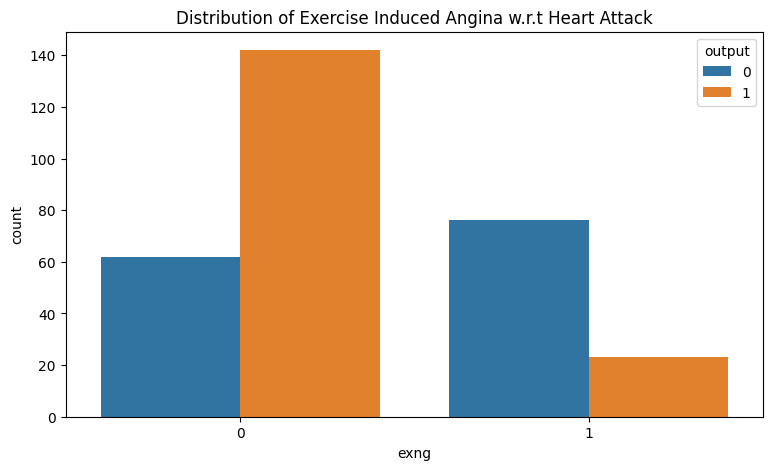

Exang heart Attack: 23.232323232323232%
No Exang heart Attack: 69.6078431372549%


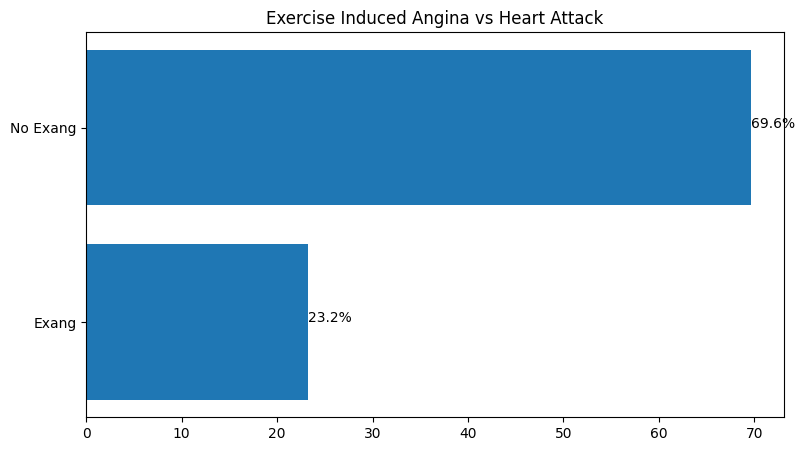

In [ ]:
plt.figure(figsize = (9,5))
sns.countplot(
    data=data,
    x = "exng",
    hue="output",
)
plt.title("Distribution of Exercise Induced Angina w.r.t Heart Attack")
plt.show()
exang_val_counts = data.groupby("exng")["output"].value_counts()
exang_heart_attack_percentage = (exang_val_counts[1][1] / (exang_val_counts[1][1]+exang_val_counts[1][0])) * 100
no_exang_heart_attack_percentage = (exang_val_counts[0][1] / (exang_val_counts[0][1]+exang_val_counts[0][0])) * 100

print(f"Exang heart Attack: {exang_heart_attack_percentage}%")
print(f"No Exang heart Attack: {no_exang_heart_attack_percentage}%")

plt.figure(figsize = (9,5))
x = ["Exang","No Exang"]
y = [exang_heart_attack_percentage,no_exang_heart_attack_percentage]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Exercise Induced Angina vs Heart Attack")
plt.show()


Từ dữ liệu trên, chúng ta có thể thấy rằng những người bị Đau thắt ngực do tập thể dục có tỷ lệ đau tim là 23,2% .
 Trong khi những người không bị Đau thắt ngực do tập thể dục có tỷ lệ đau tim là 69,6%. Do đó những người bị Đau thắt ngực do tập thể dục ít có nguy cơ bị đau tim hơn.

**Kiểm tra sự phân bố của Đau ngực liên quan đến Bệnh tim**

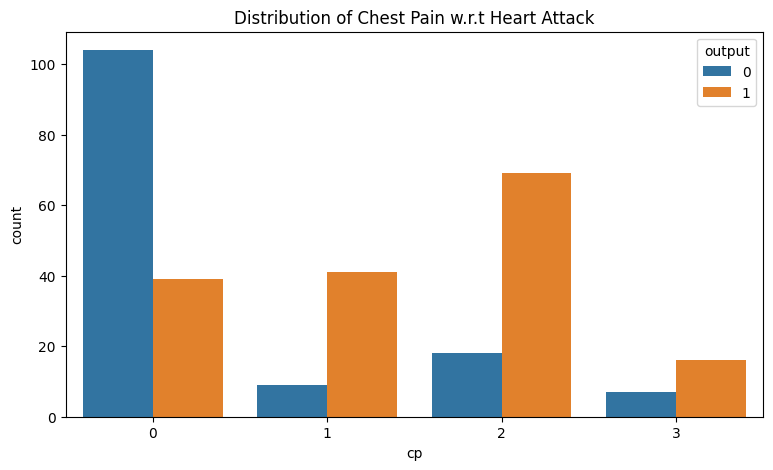

CP_0 Heart Attack Percentage: 27.27272727272727%
CP_1 Heart Attack Percentage: 82.0%
CP_2 Heart Attack Percentage: 79.3103448275862%
CP_3 Heart Attack Percentage: 69.56521739130434%



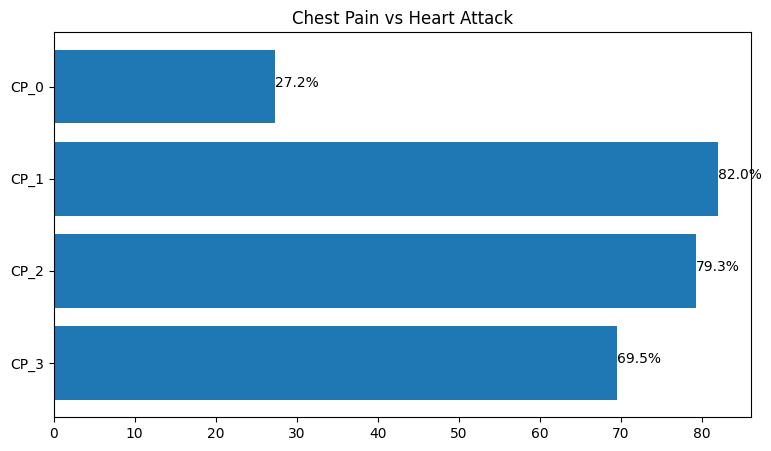

In [ ]:
plt.figure(figsize = (9,5))
sns.countplot(
    data=data,
    x = "cp",
    hue="output",
)
plt.title("Distribution of Chest Pain w.r.t Heart Attack")
plt.show()
cp_val_counts = data.groupby("cp")["output"].value_counts()

x = []
y = []

for i in range(4):
    temp_per = (cp_val_counts[i][1] / (cp_val_counts[i][1]+cp_val_counts[i][0])) * 100
    x.append("CP_"+str(i))
    y.append(temp_per)
    print(f"CP_{i} Heart Attack Percentage: {temp_per}%")

print()

plt.figure(figsize = (9,5))
plt.barh(x[::-1], y[::-1])

for index, value in enumerate(y[::-1]):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Chest Pain vs Heart Attack")
plt.show()

Những người bị đau ngực loại 1 (đau thắt ngực không điển hình) dễ bị đau tim hơn so với các loại đau ngực khác.

**Kiểm tra sự phân phối của Đường trong máu liên quan đến Bệnh tim**

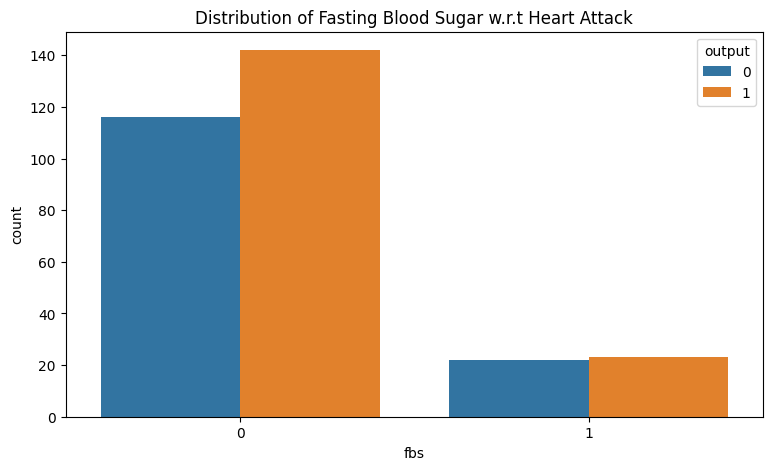

FBS heart Attack: 23.232323232323232%
No FBS heart Attack: 69.6078431372549%



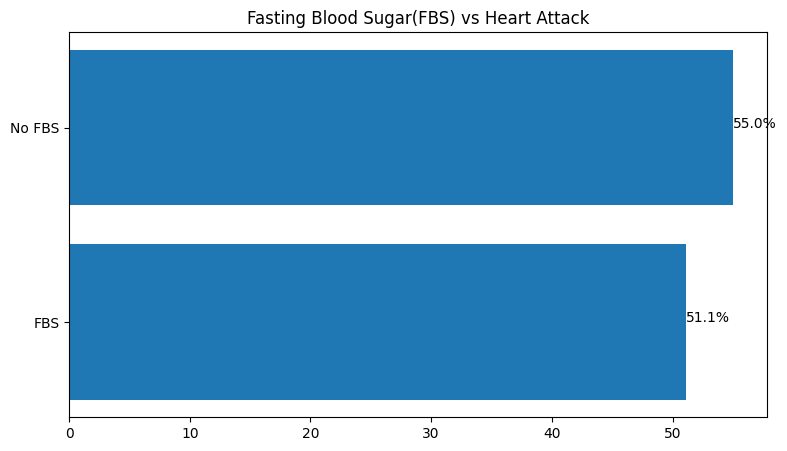

In [ ]:
plt.figure(figsize = (9,5))
sns.countplot(
    data=data,
    x = "fbs",
    hue="output",
)
plt.title("Distribution of Fasting Blood Sugar w.r.t Heart Attack")
plt.show()
fbs_val_counts = data.groupby("fbs")["output"].value_counts()
fbs_heart_attack_percentage = (fbs_val_counts[1][1] / (fbs_val_counts[1][1]+fbs_val_counts[1][0])) * 100
no_fbs_exang_heart_attack_percentage = (fbs_val_counts[0][1] / (fbs_val_counts[0][1]+fbs_val_counts[0][0])) * 100

print(f"FBS heart Attack: {exang_heart_attack_percentage}%")
print(f"No FBS heart Attack: {no_exang_heart_attack_percentage}%")

print()

plt.figure(figsize = (9,5))
x = ["FBS","No FBS"]
y = [fbs_heart_attack_percentage,no_fbs_exang_heart_attack_percentage]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Fasting Blood Sugar(FBS) vs Heart Attack")
plt.show()

Không có nhiều sự khác biệt giữa những người có FBS và những người không có FBS. Có một chút khác biệt là 4,9%

**Kiểm tra sự phân bố kết quả điện tâm đồ lúc nghỉ liên quan đến Bệnh tim**

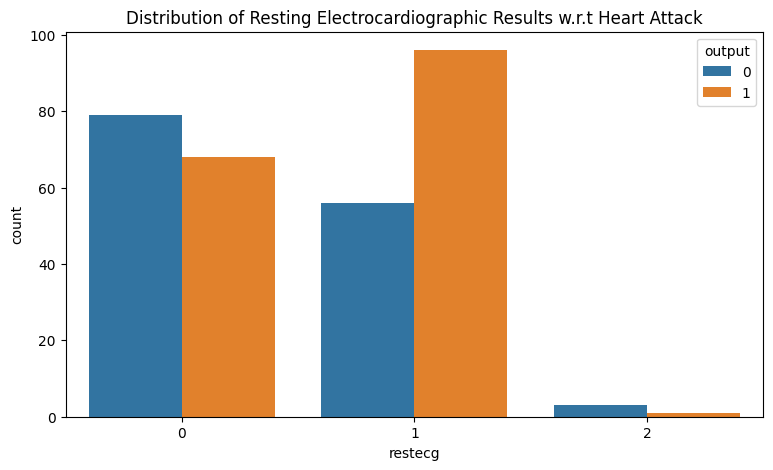

RESTECG_0 Heart Attack Percentage: 46.25850340136054%
RESTECG_1 Heart Attack Percentage: 63.1578947368421%
RESTECG_2 Heart Attack Percentage: 25.0%



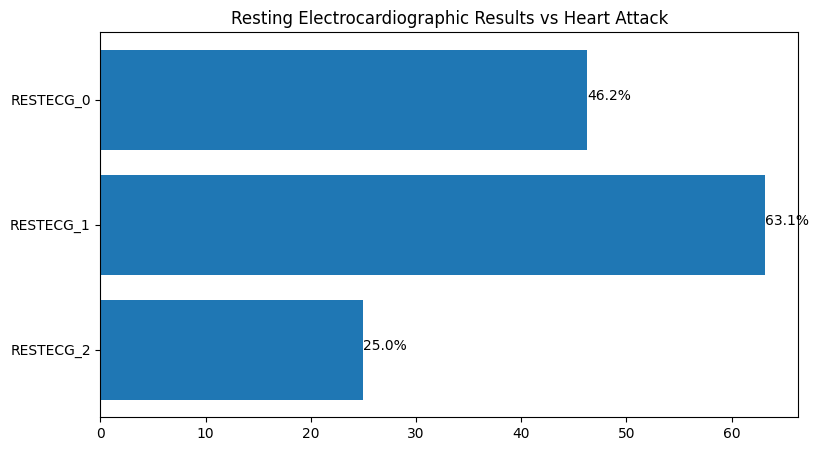

In [ ]:
plt.figure(figsize = (9,5))
sns.countplot(
    data=data,
    x = "restecg",
    hue="output",
)
plt.title("Distribution of Resting Electrocardiographic Results w.r.t Heart Attack")
plt.show()

restecg_val_counts = data.groupby("restecg")["output"].value_counts()

x = []
y = []

for i in range(3):
    temp_per = (restecg_val_counts[i][1] / (restecg_val_counts[i][1]+restecg_val_counts[i][0])) * 100
    x.append("RESTECG_"+str(i))
    y.append(temp_per)
    print(f"RESTECG_{i} Heart Attack Percentage: {temp_per}%")

print()

plt.figure(figsize = (9,5))
plt.barh(x[::-1], y[::-1])

for index, value in enumerate(y[::-1]):
    plt.text(value, index,
             str(value)[:4]+"%")

plt.title("Resting Electrocardiographic Results vs Heart Attack")
plt.show()

Những người bị RESTECG 1 dễ bị đau tim hơn do bị RESTECG 0 và RESTECG 2

KIỂM TRA SỰ PHÂN BỐ CỦA TUỔI VỚI BỆNH TIM

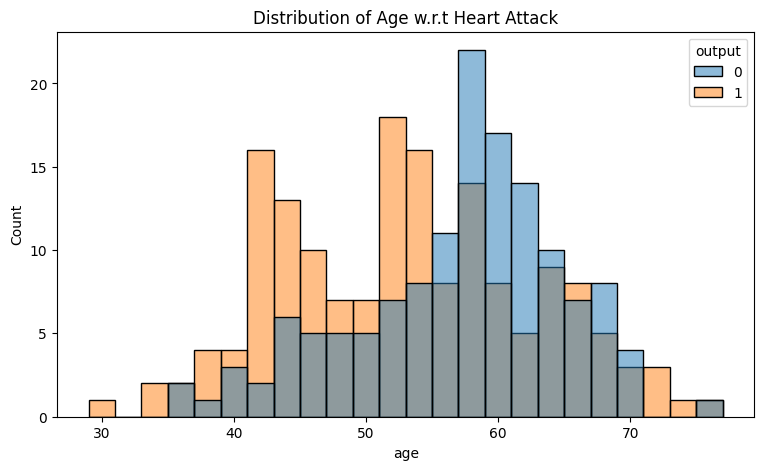

In [ ]:
ax = plt.figure(figsize = (9,5))
sns.histplot(
    data=data,
    x = "age",
    hue="output",
    binwidth=2
)
plt.title("Distribution of Age w.r.t Heart Attack")
plt.show()

Những người từ 50-70 tuổi dễ bị Đau tim hơn

BIỂU ĐỒ TƯƠNG QUAN CỦA CÁC CỘT CÓ GIÁ TRỊ LIÊN TỤC

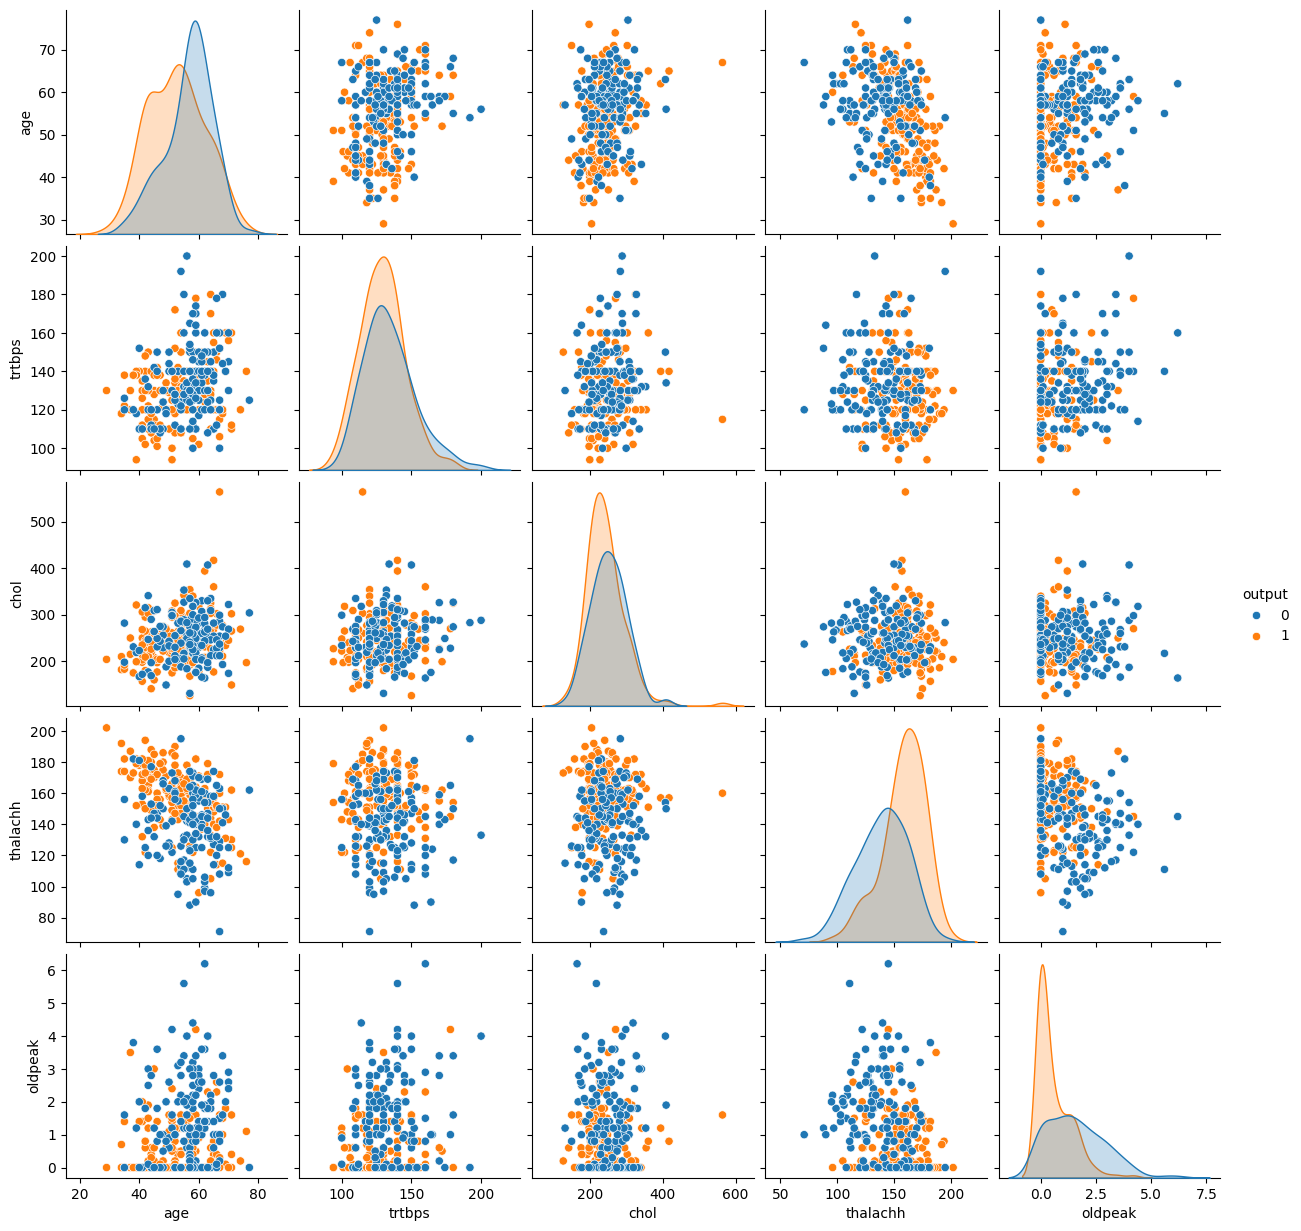

In [ ]:
continuous_var_cols = ["age", "trtbps", "chol", "thalachh", "oldpeak", "output"]

sns.pairplot(data[continuous_var_cols], hue="output")
plt.show()

**Biểu đồ phân phối cho tất cả các cột có các biến liên tục**

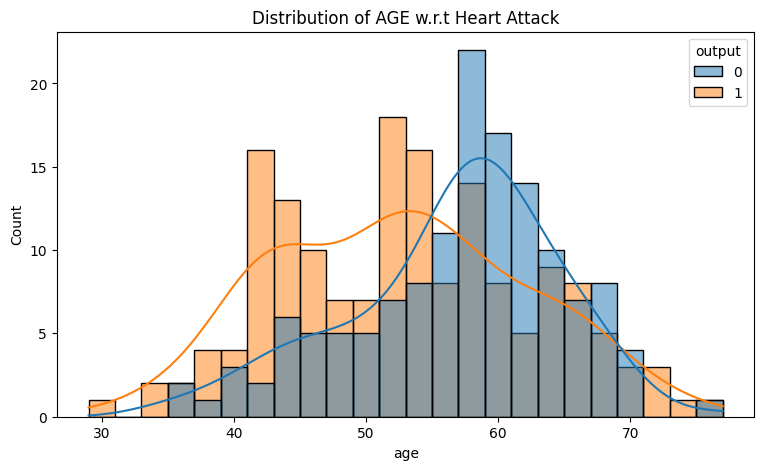

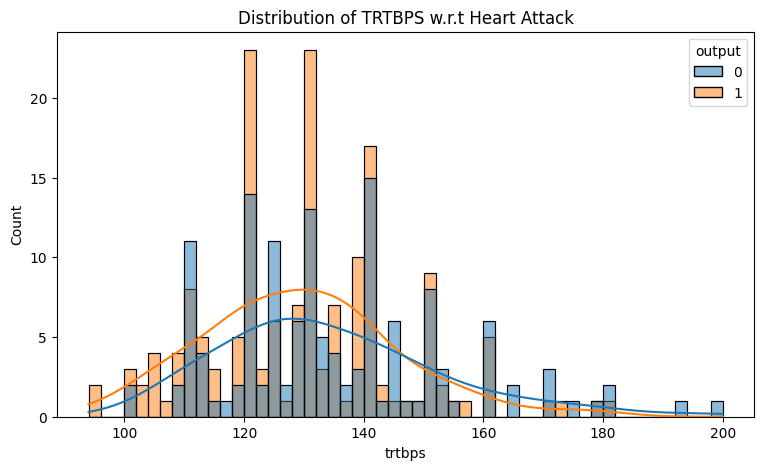

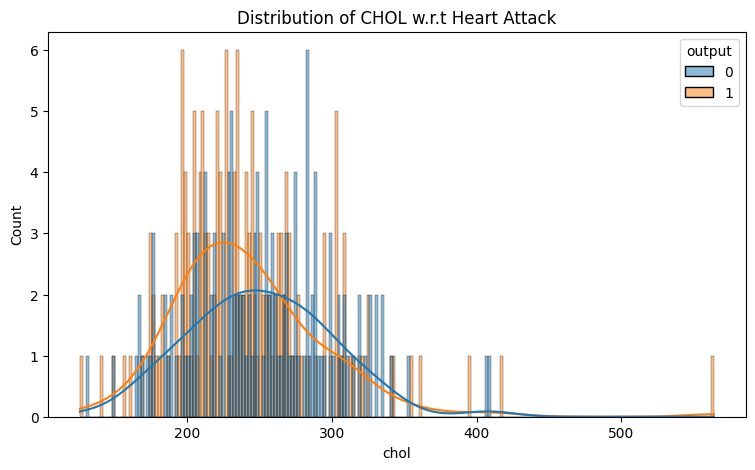

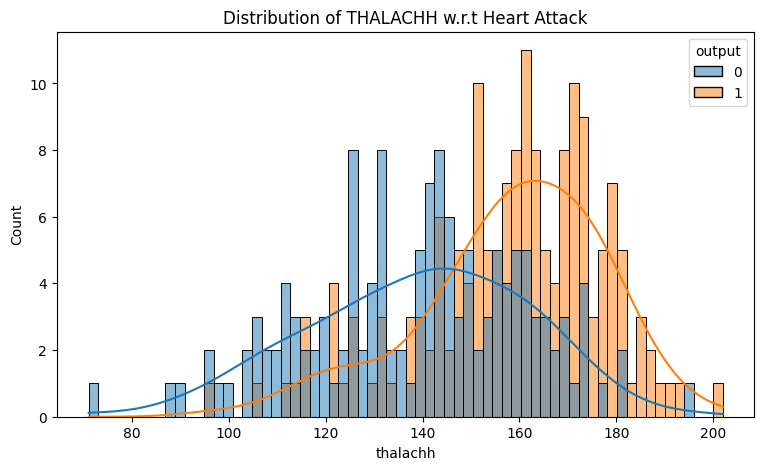

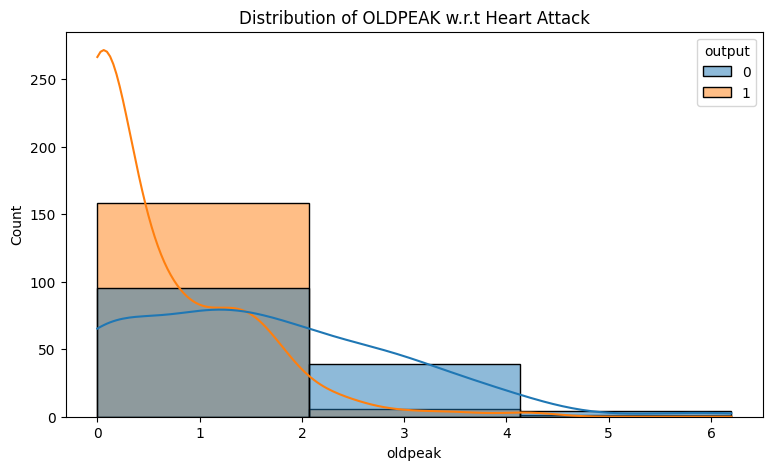

In [ ]:
for col in continuous_var_cols[:-1]:
    plt.figure(figsize = (9,5))
    sns.histplot(
        data=data,
        x = col,
        hue="output",
        binwidth=2,
        kde=True
    )
    plt.title(f"Distribution of {col.upper()} w.r.t Heart Attack")
    plt.show()
    print()

**Kiểm tra mối tương quan giữa các thuộc tính có chỉ số liên tục**

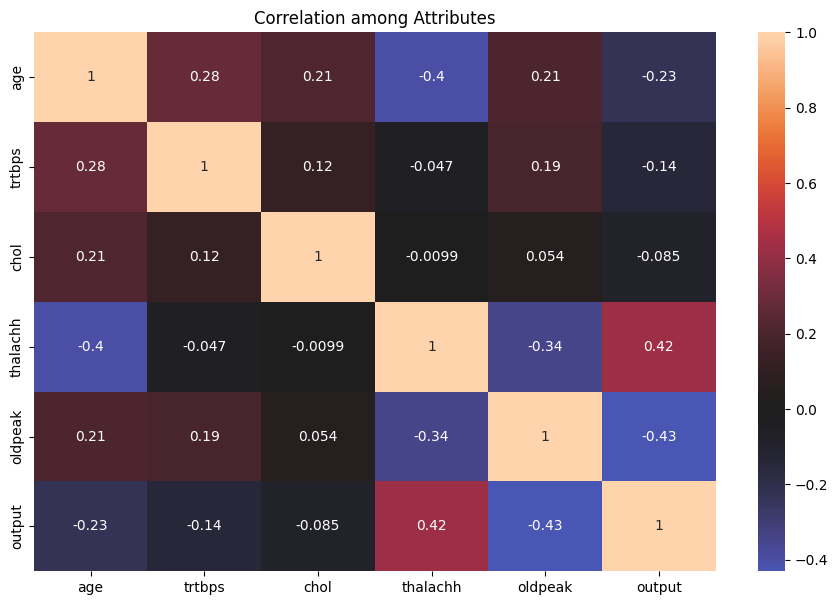

In [ ]:
corr_matrix = data[continuous_var_cols].corr()

plt.figure(figsize=(11,7))
sns.heatmap(corr_matrix, center=0, annot=True)
plt.title("Correlation among Attributes")
plt.show()

**Xây dựng mô hình dự đoán**

In [ ]:
X = data.iloc[:, 0: -1]
y = data.iloc[:, -1:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

In [ ]:
scaler = StandardScaler()

X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.fit_transform(y_test)
print(f"Train Data: {X_train.shape}, {y_train.shape}")
print(f"Test Data: {X_test.shape}, {y_test.shape}")
print('X_test: {}'.format(X_test.head(25)))
print('Y_test: {}'.format(y_test.head(25)))

Train Data: (242, 13), (242, 1)
Test Data: (61, 13), (61, 1)
X_test:      age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
225   70    1   0     145   174    0        1       125     1      2.6    0   
152   64    1   3     170   227    0        0       155     0      0.6    1   
228   59    1   3     170   288    0        0       159     0      0.2    1   
201   60    1   0     125   258    0        0       141     1      2.8    1   
52    62    1   2     130   231    0        1       146     0      1.8    1   
245   48    1   0     124   274    0        0       166     0      0.5    1   
175   40    1   0     110   167    0        0       114     1      2.0    1   
168   63    1   0     130   254    0        0       147     0      1.4    1   
223   56    0   0     200   288    1        0       133     1      4.0    0   
217   63    1   0     130   330    1        0       132     1      1.8    2   
111   57    1   2     150   126    1        1       173     0 

k = 7

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train_scaled, y_train)

knn_predicted = knn.predict(X_test_scaled)

#model fit check
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)
print('test fit score: {} %'.format(knn.score(X_test_scaled, y_test)*100))
print('train fit score: {} %'.format(knn.score(X_train_scaled, y_train)*100))
# print('Confusion matrix: {}'.format(confusion_matrix(y_test, knn_predicted)))
print('Accuracy score: {} %'.format(accuracy_score(y_test, knn_predicted)*100))
# print('X_test: {}'.format(X_test.head(25)))
# print('Y_test: {}'.format(y_test.head(25)))
print(knn_predicted)

test fit score: 81.9672131147541 %
train fit score: 85.9504132231405 %
Accuracy score: 81.9672131147541 %
[0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0
 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1]


cho k = 11

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train_scaled, y_train)

knn_predicted = knn.predict(X_test_scaled)

#model fit check
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)
print('test fit score: {} %'.format(knn.score(X_test_scaled, y_test)*100))
print('train fit score: {} %'.format(knn.score(X_train_scaled, y_train)*100))
# print('Confusion matrix: {}'.format(confusion_matrix(y_test, knn_predicted)))
print('Accuracy score: {} %'.format(accuracy_score(y_test, knn_predicted)*100))
# print('X_test: {}'.format(X_test.head(25)))
# print('Y_test: {}'.format(y_test.head(25)))
print(knn_predicted)

test fit score: 85.24590163934425 %
train fit score: 84.71074380165288 %
Accuracy score: 85.24590163934425 %
[0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0
 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1]


In [ ]:
data.head(300)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,63,1,0,140,187,0,0,144,1,4.0,2,2,3,0
296,63,0,0,124,197,0,1,136,1,0.0,1,0,2,0
297,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0


Thử EXample

In [ ]:

# Tạo DataFrame test ban đầu
test = pd.DataFrame({
    "age": [41],
    "sex": [0],
    "cp": [1],
    "trtbps": [130],
    "chol": [204],
    "fbs": [0],
    "restecg": [0],
    "thalachh": [172],
    "exng": [0],
    "oldpeak": [1.4],
    "slp": [2],
    "caa": [0],
    "thall": [2]
})
# Kết hợp DataFrame test với DataFrame X_test bằng phương thức concat()
test = pd.concat([test, X_test], ignore_index=True)
test_scaler = scaler.fit_transform(test)
predicted= knn.predict(test_scaler)
print(test)
print('kết quả: ',predicted[0])





    age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0    41    0   1     130   204    0        0       172     0      1.4    2   
1    70    1   0     145   174    0        1       125     1      2.6    0   
2    64    1   3     170   227    0        0       155     0      0.6    1   
3    59    1   3     170   288    0        0       159     0      0.2    1   
4    60    1   0     125   258    0        0       141     1      2.8    1   
..  ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
57   44    0   2     118   242    0        1       149     0      0.3    1   
58   57    0   1     130   236    0        0       174     0      0.0    1   
59   59    1   2     150   212    1        1       157     0      1.6    2   
60   50    0   1     120   244    0        1       162     0      1.1    2   
61   58    0   0     100   248    0        0       122     0      1.0    1   

    caa  thall  
0     0      2  
1     0      3  
2     0     

DECISION TREE

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import export_text

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv("/content/drive/MyDrive/PTDL/heart.csv")  # Thay đổi đường dẫn đến tệp CSV của bạn

# Chọn các cột đặc trưng và cột nhãn
features = ["age", "sex", "cp", "trtbps", "chol", "fbs", "restecg", "thalachh", "exng", "oldpeak", "slp", "caa", "thall"]
X = data[features]
y = data["output"]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng mô hình cây quyết định
clf = DecisionTreeClassifier(max_depth=10)  # Có thể điều chỉnh max_depth tùy ý
clf.fit(X, y)




# # Báo cáo chi tiết
# report = classification_report(y_test, y_pred)
# print('Classification Report:\n', report)


# Tạo biểu diễn đồ thị của cây quyết định
dot_data = export_graphviz(clf, out_file=None,
                           feature_names=features,
                           class_names=["0", "1"],
                           filled=True, rounded=True,
                           special_characters=True)

# Hiển thị đồ thị
graph = graphviz.Source(dot_data)
graph.render(filename='/content/drive/MyDrive/PTDL/tree', format='png', cleanup=True)
graph.view()

# Xem và nhận xét bộ luật của cây quyết định
tree_rules = export_text(clf, feature_names=features)
print("Decision Tree Rules:")
print(tree_rules)



Decision Tree Rules:
|--- cp <= 0.50
|   |--- caa <= 0.50
|   |   |--- thall <= 2.50
|   |   |   |--- exng <= 0.50
|   |   |   |   |--- thalachh <= 96.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- thalachh >  96.50
|   |   |   |   |   |--- chol <= 316.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- chol >  316.50
|   |   |   |   |   |   |--- slp <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- slp >  1.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- exng >  0.50
|   |   |   |   |--- restecg <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- restecg >  0.50
|   |   |   |   |   |--- slp <= 1.50
|   |   |   |   |   |   |--- trtbps <= 115.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- trtbps >  115.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- slp >  1.50
|   |   |   |   |   |   |--- class: 1
|   |   |--- thall >  2.50
|   |   |   |--- oldpeak <= 0.65
|  

NaiVe Bayes

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Đọc dữ liệu từ file CSV hoặc từ nguồn dữ liệu khác
data = pd.read_csv("/content/drive/MyDrive/PTDL/heart.csv")

# Chia dữ liệu thành features (đặc trưng) và target (mục tiêu)
X = data.drop('output', axis=1)
y = data['output']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = nb_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.8688524590163934
Confusion Matrix:
 [[26  3]
 [ 5 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



Đồ thị sai số


In [ ]:
import pandas as pd
# Chia tập dữ liệu thành tập train (80%) và tập test (20%):
from sklearn.model_selection import train_test_split


X = data.drop('output', axis=1)
y = data['output']
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=30)


In [ ]:
# Xây dựng mô hình KNN với K lần lượt là 3, 5, 7, 9 trên tập train:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_9 = KNeighborsClassifier(n_neighbors=9)
knn_11 = KNeighborsClassifier(n_neighbors=11)
knn_3.fit(X_train, y_train)
knn_5.fit(X_train, y_train)
knn_7.fit(X_train, y_train)
knn_9.fit(X_train, y_train)
knn_11.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [ ]:
# Đánh giá mô hình trên tập test:
y_pred_3 = knn_3.predict(X_test)
y_pred_5 = knn_5.predict(X_test)
y_pred_7 = knn_7.predict(X_test)
y_pred_9 = knn_9.predict(X_test)
y_pred_11 = knn_11.predict(X_test)

In [ ]:
# Tính toán sai số trên tập train và test:
from sklearn.metrics import accuracy_score

train_error_3 = 1 - accuracy_score(y_train, knn_3.predict(X_train))
test_error_3 = 1 - accuracy_score(y_test, y_pred_3)

train_error_5 = 1 - accuracy_score(y_train, knn_5.predict(X_train))
test_error_5 = 1 - accuracy_score(y_test, y_pred_5)

train_error_7 = 1 - accuracy_score(y_train, knn_7.predict(X_train))
test_error_7 = 1 - accuracy_score(y_test, y_pred_7)

train_error_9 = 1 - accuracy_score(y_train, knn_9.predict(X_train))
test_error_9 = 1 - accuracy_score(y_test, y_pred_9)

train_error_11 = 1 - accuracy_score(y_train, knn_11.predict(X_train))
test_error_11 = 1 - accuracy_score(y_test, y_pred_11)

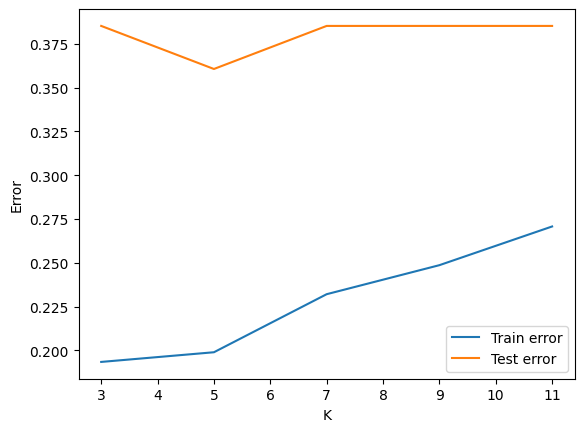

,K,Train Error,Test Error
0,3,0.193370,0.385246
1,5,0.198895,0.360656
2,7,0.232044,0.385246
3,9,0.248619,0.385246
4,11,0.270718,0.385246


In [ ]:
# Vẽ đồ thị sai số:
import matplotlib.pyplot as plt

plt.plot([3,5,7,9,11], [train_error_3, train_error_5, train_error_7, train_error_9, train_error_11], label='Train error')
plt.plot([3,5,7,9,11], [test_error_3, test_error_5, test_error_7, test_error_9, test_error_11], label='Test error')

plt.xlabel('K')
plt.ylabel('Error')
plt.legend()

plt.show()
# Xuất thành dạng bảng:
K_values = [3, 5, 7, 9, 11]
train_errors = [train_error_3, train_error_5, train_error_7, train_error_9, train_error_11]
test_errors = [test_error_3, test_error_5, test_error_7, test_error_9, test_error_11]

# Tạo dataframe từ các list trên
df_demo = pd.DataFrame({'K': K_values,
                  'Train Error': train_errors,
                  'Test Error': test_errors})

# Xuất dataframe ra file .csv
df_demo

# Xét điểm dữ liệu có Test_error thấp nhất làm K-Best -> xét thêm K=11 để đảm bảo không có giảm thêm!
# => K best = 9


Luật Kết Hợp


In [ ]:
## Dùng Luật kết hợp
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
data_copy = data[["age",	"sex",	"cp",	"trtbps"	,"chol",	"fbs",	"restecg",	"thalachh"	,"exng"	,"oldpeak",	"slp"	,"caa"	,"thall"]]

data_copy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [ ]:
#in ra giá trị lớn nhất của từng cột
print(f"age: {data_copy['age'].max()}")
print(f"sex: {data_copy['sex'].max()}")
print(f"cp: {data_copy['cp'].max()}")
print(f"trtbps: {data_copy['trtbps'].max()}")
print(f"chol: {data_copy['chol'].max()}")
print(f"restecg: {data_copy['restecg'].max()}")
print(f"thalachh: {data_copy['thalachh'].max()}")
print(f"fbs: {data_copy['fbs'].max()}")
print(f"exng: {data_copy['exng'].max()}")
print(f"oldpeak: {data_copy['oldpeak'].max()}")
print(f"slp: {data_copy['slp'].max()}")
print(f"caa: {data_copy['caa'].max()}")
print(f"thall: {data_copy['thall'].max()}")

age: 77
sex: 1
cp: 3
trtbps: 200
chol: 564
restecg: 2
thalachh: 202
fbs: 1
exng: 1
oldpeak: 6.2
slp: 2
caa: 4
thall: 3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Thay đổi dữ liệu theo điều kiện

# Tạo hàm để tiện trong việc chuẩn hóa 1/0
def apply_rule(value, threshold):
    return 1 if value > threshold else 0

# Tạo một mảng threshold của từng cột
# Chọn giá trị ngưỡng sao cho giá trị ngưỡng chia cho giá trị max ở từng cột sẽ gần bằng với 0.7 nhất
thresholds = {'age': 54, 'cp': 2.1, 'trtbps': 141.5, 'chol': 399.5, 'restecg': 1.4, 'thalachh': 142.5, 'oldpeak': 4.4, 'slp': 1.4, 'caa':2.8, 'thall':2.1}

for column, threshold in thresholds.items():
    data_copy[column] = data_copy[column].apply(apply_rule, threshold=threshold)

print(data_copy)

     age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0      1    1   1       1     0    1        0         1     0        0    0   
1      0    1   0       0     0    0        0         1     0        0    0   
2      0    0   0       0     0    0        0         1     0        0    1   
3      1    1   0       0     0    0        0         1     0        0    1   
4      1    0   0       0     0    0        0         1     1        0    1   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298    1    0   0       0     0    0        0         0     1        0    0   
299    0    1   1       0     0    0        0         0     0        0    0   
300    1    1   0       1     0    1        0         0     0        0    0   
301    1    1   0       0     0    0        0         0     1        0    0   
302    1    0   0       0     0    0        0         1     0        0    0   

     caa  thall  
0      0      0  
1      0      0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Chuyển đổi dữ liệu thành dạng One-Hot Encoding
data_encoded = data_copy.applymap(lambda x: True if x == 1 else False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Áp dụng thuật toán Apriori để tìm các luật kết hợp
frequent_itemsets = apriori(data_encoded, min_support=0.1, use_colnames=True)

# Tìm các luật kết hợp dựa trên frequent itemsets và độ tin cậy
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

print(rules)

           antecedents consequents  antecedent support  consequent support  \
0             (trtbps)       (age)            0.214521            0.524752   
1                (fbs)       (sex)            0.148515            0.683168   
2               (exng)       (sex)            0.326733            0.683168   
3              (thall)       (sex)            0.386139            0.683168   
4                (slp)  (thalachh)            0.468647            0.669967   
5        (sex, trtbps)       (age)            0.141914            0.524752   
6          (age, exng)       (sex)            0.201320            0.683168   
7         (age, thall)       (sex)            0.237624            0.683168   
8           (age, slp)  (thalachh)            0.191419            0.669967   
9           (sex, slp)  (thalachh)            0.316832            0.669967   
10   (thalachh, thall)       (sex)            0.214521            0.683168   
11       (exng, thall)       (sex)            0.194719          

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
rules.to_excel("/content/drive/MyDrive/PTDL/heartcopy.xlsx")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Gom cụm theo số tuổi và nhịp tim đạt được


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


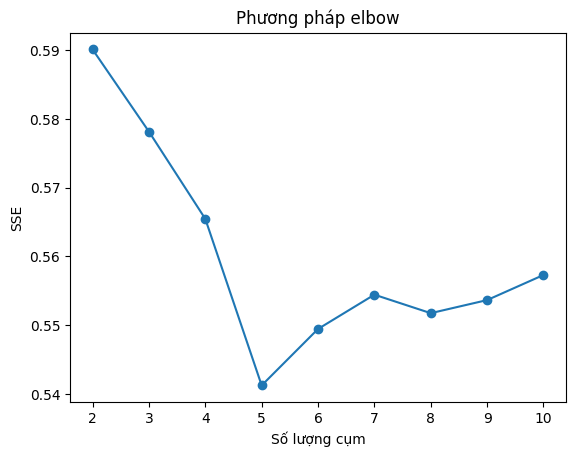

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

max_clusters = 10  # Số cụm tối đa muốn xem
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[['age']])
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(data[['age']], labels))

# Vẽ biểu đồ elbow
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm')
plt.ylabel('SSE')
plt.title('Phương pháp elbow')
plt.show()


In [ ]:
# Số cụm tối ưu dựa trên biểu đồ Elbow
num_clusters = 5

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Áp dụng thuật toán K-means
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(data[["age"]])

# Trích xuất nhãn cụm cho mỗi mẫu dữ liệu
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


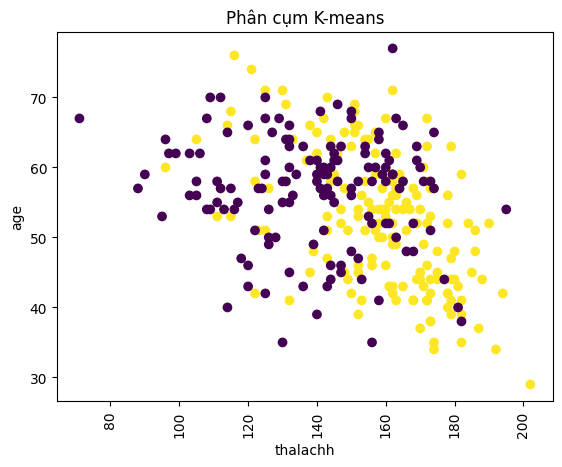

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sử dụng hàm explode() để tách các thể loại phim ra thành các hàng riêng lẻ
data_exploded = data.explode('thalachh')

plt.scatter(data_exploded['thalachh'], data_exploded['age'], c=data_exploded['output'], cmap='viridis')
plt.xlabel('thalachh')
plt.ylabel('age')
plt.title('Phân cụm K-means')
plt.xticks(rotation=90)  # Xoay nhãn trên trục x để tránh chồng chéo
plt.show()


In [ ]:
# lọc các nước ở cụm tím
filtered_df = data[(data['output'] == 0.0) ]
filtered_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
165,67,1,0,160,286,0,0,108,1,1.5,1,3,2,0
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3,0
167,62,0,0,140,268,0,0,160,0,3.6,0,2,2,0
168,63,1,0,130,254,0,0,147,0,1.4,1,1,3,0
169,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [ ]:
# lọc các nước ở cụm vàng
filtered_df = data[(data['output'] == 1.0) ]
filtered_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,56,1,1,120,240,0,1,169,0,0.0,0,0,2,1
161,55,0,1,132,342,0,1,166,0,1.2,2,0,2,1
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
